In [1]:
import os 
import pandas as pd
import glob 
import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np

os.chdir('/mnt/BioHome/jreyna/jreyna/projects/dchallenge/')

outdir = 'results/notebooks/colocalization_with_eqtl_catalogue/'
os.makedirs(outdir, exist_ok=True)

## Loading the gencode reference

In [2]:
gencode = pd.read_table('results/refs/gencode/v30/gencode.v30.annotation.bed', header=None)
gencode = gencode.iloc[:, [5,6]]
gencode.set_index(6, inplace=True)
gencode = gencode.squeeze()
gencode = gencode.to_dict()
rev_gencode = {v:k for k,v in gencode.items()}

## Loading and processing the coloc data 

In [3]:
data = []
coloc_glob = 'results/main/coloc/Results/eQTL_Catalogue/T1D_34012112_Gaulton/*/*/FINAL_Summary_Coloc_Gene_SNP_Pairs.bed'
coloc_fns = sorted(glob.glob(coloc_glob))
coloc_fns = [x for x in coloc_fns if 'test' not in x]
old_colocs = 17 #en(coloc_fns)
print('Number of colocalizations analyses: {}.'.format(len(coloc_fns)))

Number of colocalizations analyses: 20.


In [4]:
for fn in coloc_fns:
    
    # load the data
    df = pd.read_table(fn)
    
    # get GWAS, eQTL and gene expression sources
    fname_segs = fn.split('/')
    gwas = fname_segs[5]
    eqtl = fname_segs[6]
    ge = fname_segs[7]
    
    # assign the current values
    df['gwas'] = gwas
    df['eqtl'] = eqtl
    df['ge'] = ge
    data.append(df)
    
t1d_data = pd.concat(data)

In [5]:
# add the gene name
t1d_data['gene_name'] = t1d_data.geneName.replace(rev_gencode)

In [6]:
# removing duplicate SNP-gene pairs by find the one with the largest PP4
t1d_data_rgs = t1d_data.groupby(['gwas', 'eqtl', 'ge', 'rs_id', 'geneName'])
new_t1d_data = []
for grp, grp_df in t1d_data_rgs:
    max_index = np.argmax(grp_df.pp_H4_Coloc_Summary)
    new_t1d = grp_df.iloc[max_index,:]
    new_t1d_data.append(new_t1d)
new_t1d_data = pd.DataFrame(new_t1d_data)
new_t1d_data.reset_index(drop=True, inplace=True)

# assigning t1d_data to the new dataset
t1d_data = new_t1d_data

In [7]:
tdf = t1d_data[['chr', 'pos','rs_id', 'variant_id', 'geneName','pp_H4_Coloc_Summary', 'dist', 'pvalue', 'FDR', 'slope_snp',
       'slope_se_snp', 'slope_gwas', 'slope_se_gwas', 'pval_nominal', 'SampleSize', 'gwas', 'eqtl', 'ge',
       'gene_name']].sort_values(['eqtl', 'ge', 'rs_id']).set_index(['eqtl', 'ge', 'rs_id'])

In [8]:
tdf[tdf.FDR < 0.05].gene_name.unique()

array(['AC068254.1', 'DOK6', 'AC027228.1'], dtype=object)

## Checking the data sources

In [9]:
check_sources = t1d_data.drop_duplicates(['eqtl', 'ge'])
check_sources = check_sources[['eqtl', 'ge']]

In [10]:
pd.set_option('display.max_rows', 100) 
display(check_sources.set_index('eqtl'))
pd.set_option('display.max_rows', 20) 

,ge
eqtl,
BLUEPRINT,T-cell
BLUEPRINT,monocyte
BLUEPRINT,neutrophil
GTEx,LCL
Quach_2016,monocyte_IAV
Quach_2016,monocyte_Pam3CSK4
Quach_2016,monocyte_R848
Schmiedel_2018,B-cell_naive
Schmiedel_2018,CD4_T-cell_anti-CD3-CD28


## Plotting the Number of SNP-Gene Pairs

In [11]:
study_summary = t1d_data.value_counts(['gwas', 'eqtl', 'ge']).to_frame().reset_index()
study_summary.rename(columns={0:'count'}, inplace=True)

Text(19.015271086516208, 0.5, 'Count')

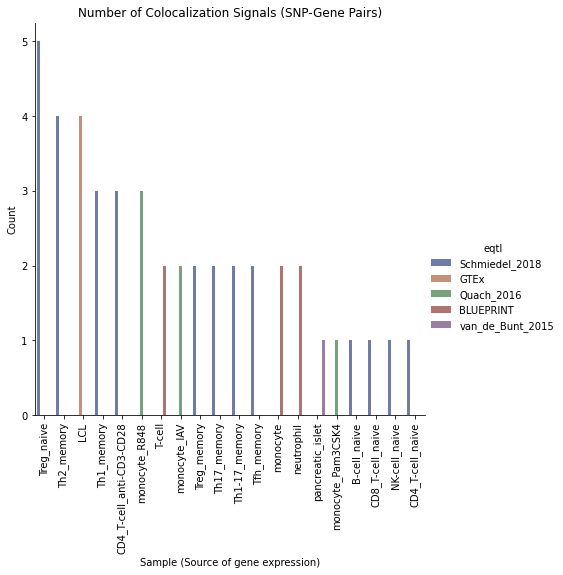

In [12]:
#sns.barplot(hue='eqtl', y='count', x='ge', data=study_summary)

# fig, ax = plt.subplots()
# Draw a nested barplot by species and sex
g= sns.catplot(data=study_summary, kind="bar",
            x="ge", y="count", hue="eqtl",
            ci="sd", palette="dark", alpha=.6, height=6)

for x in g.ax.get_xticklabels():
    x.set_rotation(90)
    
g.ax.set_title('Number of Colocalization Signals (SNP-Gene Pairs)')
g.ax.set_xlabel('Sample (Source of gene expression)')
g.ax.set_ylabel('Count')

In [13]:
study_report_fn = os.path.join(outdir, 'coloc_report.tsv')
study_summary.to_csv(study_report_fn, sep='\t', index=False)

## Plotting the Number of Unique Genes per Colocalization Analysis

In [14]:
uniq_genes_per_sample = t1d_data.groupby(['eqtl', 'ge']).geneName.nunique()
uniq_genes_per_sample = uniq_genes_per_sample.reset_index()

Text(14.116854745370379, 0.5, 'Count')

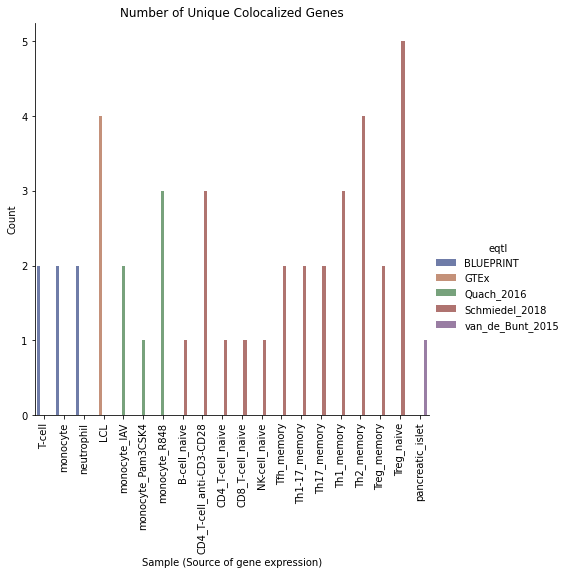

In [15]:
#sns.barplot(hue='eqtl', y='count', x='ge', data=study_summary)

# fig, ax = plt.subplots()
# Draw a nested barplot by species and sex
g= sns.catplot(data=uniq_genes_per_sample, kind="bar",
            x="ge", y="geneName", hue="eqtl",
            ci="sd", palette="dark", alpha=.6, height=6)

for x in g.ax.get_xticklabels():
    x.set_rotation(90)
    
g.ax.set_title('Number of Unique Colocalized Genes')
g.ax.set_xlabel('Sample (Source of gene expression)')
g.ax.set_ylabel('Count')

In [16]:
# find the uniq snps
uniq_snps_per_samples = t1d_data.groupby(['eqtl', 'ge']).rs_id.nunique().reset_index()

In [17]:
# concat the two tables
uniq_summary = uniq_genes_per_sample.merge(uniq_snps_per_samples)
uniq_summary.columns = ['eqtl', 'ge', 'Unique # Genes', 'Unique # SNPs']

### Table for the number of unique genes and snps per colocalization analyses

In [18]:
pd.set_option('display.max_rows', 100) 
display(uniq_summary.sort_values('Unique # SNPs', ascending=False))
pd.set_option('display.max_rows', 20) 

,eqtl,ge,Unique # Genes,Unique # SNPs
18,Schmiedel_2018,Treg_naive,5,5
3,GTEx,LCL,4,4
16,Schmiedel_2018,Th2_memory,4,4
6,Quach_2016,monocyte_R848,3,3
8,Schmiedel_2018,CD4_T-cell_anti-CD3-CD28,3,3
15,Schmiedel_2018,Th1_memory,3,3
0,BLUEPRINT,T-cell,2,2
14,Schmiedel_2018,Th17_memory,2,2
2,BLUEPRINT,neutrophil,2,2
4,Quach_2016,monocyte_IAV,2,2


## Summarizing the Unique Genes Combined Across all Colocalization Analyses

In [19]:
# construct a table of unique genes 
gene_uniq_summary = t1d_data.drop_duplicates(['eqtl', 'ge', 'gene_name']).gene_name.value_counts()
gene_uniq_summary = gene_uniq_summary.to_frame()
gene_uniq_summary.sort_values('gene_name', ascending=False, inplace=True)
gene_uniq_summary.columns = ['Number of Unique Colocalizations per Gene in ALL Studies']

print('There are {} unique genes in the whole dataset.'.format(gene_uniq_summary.shape[0]))

# display this table
pd.set_option('display.max_rows', gene_uniq_summary.shape[0]) 
display(gene_uniq_summary)
pd.set_option('display.max_rows', 20) 

There are 31 unique genes in the whole dataset.


,Number of Unique Colocalizations per Gene in ALL Studies
GLIS3,4
DOK6,3
LINC01031,3
AC068254.1,2
NPIPB15,2
AL163932.1,2
AL354760.1,2
AL359317.1,2
AC008063.1,2
CACHD1,1


In [20]:
# save an enrichr file 
enrichr_fn = os.path.join(outdir, 'enrichr.input.txt')
with open(enrichr_fn, 'w') as fw:
    for x in sorted(gene_uniq_summary.index.tolist()):
        print(x, file=fw)
        print(x)

AC008063.1
AC008063.2
AC016747.2
AC027228.1
AC068254.1
AC091563.1
ACTA2
AL133370.1
AL133445.2
AL137856.1
AL157394.2
AL157871.5
AL163932.1
AL354760.1
AL354977.2
AL359317.1
CACHD1
DOK6
DPP4
DSCC1
GLIS3
HUS1B
IRF4
LINC01031
LINC02285
LINC02320
NPIPB15
RGS1
ROR1
TNFRSF11B
TRIM61
